# Lab | QLoRA Tuning using PEFT from Hugging Face

<!-- ### Introduction to Quantization & Fine-tune a Quantized Model -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.

# Brief Introduction to Quantization
The main idea of quantization is simple: Reduce the precision of floating-point numbers, which normally occupy 32 bits, to integers of 8 or even 4 bits.

This reduction occurs in the model’s parameters, specifically in the weights of the neural layers, and in the activation values that flow through the model’s layers.

This means that we not only achieve an improvement in the model’s storage size and memory consumption but also greater agility in its calculations.

Naturally, there is a loss of precision, but particularly in the case of 8-bit quantization, this loss is minimal.



## Let's see a example of a quantized number.

In reality, what I want to examine is the precision loss that occurs when transitioning from a 32-bit number to a quantized 8/4-bit number and then returning to its original 32-bit value.

First, I'm going to create a function to quantize and another to unquantize.

In [10]:
# Uninstall old versions just in case
!pip uninstall -y bitsandbytes triton accelerate transformers

# Reinstall required versions
!pip install bitsandbytes==0.43.1
!pip install triton==2.1.0
!pip install accelerate==0.29.3
!pip install transformers==4.40.0
!pip install peft==0.10.0
!pip install trl==0.8.6




  Using cached bitsandbytes-0.46.0-py3-none-manylinux_2_24_x86_64.whl.metadata (10 kB)
Using cached bitsandbytes-0.46.0-py3-none-manylinux_2_24_x86_64.whl (67.0 MB)
  Attempting uninstall: bitsandbytes
    Found existing installation: bitsandbytes 0.43.1
    Uninstalling bitsandbytes-0.43.1:
      Successfully uninstalled bitsandbytes-0.43.1
  Using cached triton-2.1.0-0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.3 kB)
Using cached triton-2.1.0-0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (89.2 MB)
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires triton==3.2.0; platform_system == "Linux" and platform_machine == "x86_64", but you have triton 2.

In [1]:
#Importing necesary linbraries
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
#Functions to quantize and unquantize
def quantize(value, bits=4):
    quantized_value = np.round(value * (2**(bits - 1) - 1))
    return int(quantized_value)

def unquantize(quantized_value, bits=4):
    value = quantized_value / (2**(bits - 1) - 1)
    return float(value)

Quatizied values:

In [4]:
quant_4 = quantize(0.622, 4)
print (quant_4)
quant_8 = quantize(0.622, 8)
print(quant_8)

4
79


Unquantized values:

In [4]:
unquant_4 = unquantize(quant_4, 4)
print(unquant_4)
unquant_8 = unquantize(quant_8, 8)
print(unquant_8)

0.5714285714285714
0.6220472440944882


If we consider that the original number was 0.622, it can be said that 8-bit quantization barely loses precision, and the loss from 4-bit quantization is manageable.

In [5]:

x = np.linspace(-1, 1, 50)
y = [math.cos(val) for val in x]


y_quant_8bit = np.array([quantize(val, bits=8) for val in y])
y_unquant_8bit = np.array([unquantize(val, bits=8) for val in y_quant_8bit])

y_quant_4bit = np.array([quantize(val, bits=4) for val in y])
y_unquant_4bit = np.array([unquantize(val, bits=4) for val in y_quant_4bit])


Let’s plot a curve with the unquantized values of a cosine.


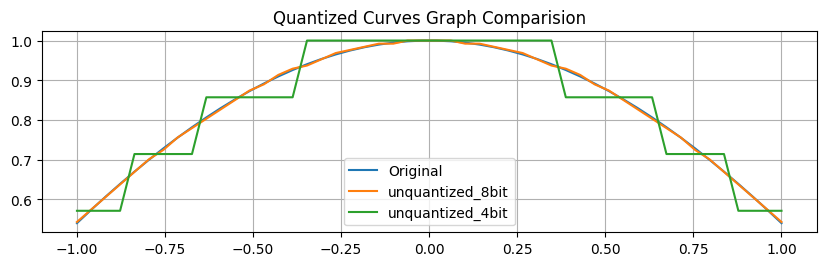

In [6]:
plt.figure(figsize=(10, 12))

plt.subplot(4, 1, 1)
plt.plot(x, y, label="Original")
plt.plot(x, y_unquant_8bit, label="unquantized_8bit")
plt.plot(x, y_unquant_4bit, label="unquantized_4bit")
plt.legend()
plt.title("Quantized Curves Graph Comparision")
plt.grid(True)

As you can see, the difference between the 8-bit and the original values is minimal. However, we need to use 4-bit quantization if we want to load the 7B Model into a 16GB GPU without problems.


# QLoRA. Fine-tuning a 4-bit Quantized Model using LoRA.
We are going to fine-tune with LoRA a 7B Model Quantizated to 4 bits.

## Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [2]:
!pip install -q accelerate==0.29.3
!pip install -q bitsandbytes==0.43.1
!pip install -q trl==0.8.6
!pip install -q peft==0.10.0
!pip install -q transformers==4.40.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
trl 0.18.1 requires accelerate>=0.34.0, but you have accelerate 0.29.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.0 which is incompatible.


I'm going to download the peft and Transformers libraries from their repositories on GitHub instead of using pip. This is not strictly necessary, but this way, you can get the newest versions of the libraries with support for newer models. If you want to check one of the latest models, you can use this trick.


In [3]:
# Install the lastest versions of peft & transformers library recommended
# if you want to work with the most recent models
!pip install -q git+https://github.com/huggingface/peft.git
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


From the Transformers library, we import the necessary classes to load the model and the tokenizer.

The notebook is ready to work with different Models I tested it with models from the Bloom Family and Llama-3.

I recommend you to test different models.

In [6]:
!pip install -U accelerate
!pip install -U trl


  Using cached triton-3.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.4 kB)
Using cached triton-3.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (253.2 MB)
  Attempting uninstall: triton
    Found existing installation: triton 2.1.0
    Uninstalling triton-2.1.0:
      Successfully uninstalled triton-2.1.0


In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import SFTTrainer
import torch

## Hugging Face login


In [2]:
from huggingface_hub import login
from getpass import getpass

hf_token = getpass("")
login(token=hf_token)


··········


## Load Model

In [3]:
#Use any model you want, if you want to do some fast test, just use the smallest one.

#model_name = "bigscience/bloomz-560m"
#model_name="bigscience/bloom-1b1"
#model_name = "bigscience/bloom-7b1"
#target_modules = ["query_key_value"]

model_name = "EleutherAI/gpt-neo-125M"
target_modules = ["q_proj", "v_proj"] #YOU MAY CHANGE THIS BASED ON YOUR MODEL ["q_proj", "v_proj"]

In [11]:
# model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M")
# for name, _ in model.named_parameters():
#     if "proj" in name.lower():
#         print(name)


To load the model, we need a configuration class that specifies how we want the quantization to be performed. We’ll achieve this with the BitesAndBytesConfig from the Transformers library.

In [4]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

We are specifying the use of 4-bit quantization and also enabling double quantization to reduce the precision loss.

For the bnb_4bit_quant_type parameter, I've used the recommended value in the paper [QLoRA: Efficient Finetuning of Quantized LLMs.](https://arxiv.org/abs/2305.14314)

Now, we can go ahead and load the model.

In [57]:
device_map = {"": 0}
foundation_model = AutoModelForCausalLM.from_pretrained(model_name,
                    quantization_config=bnb_config,
                    device_map=device_map,
                    use_cache = False)



Now we have the quantized version of the model in memory. Yo can try to load the unquantized version to see if it's possible.

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_name,padding_side="left")
tokenizer.pad_token = tokenizer.eos_token


## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [58]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100):
    """
    Generate text using the given model and inputs.

    Args:
        model: The pretrained or fine-tuned language model.
        inputs: A dictionary containing 'input_ids' and 'attention_mask'.
        max_new_tokens: The max number of tokens to generate after the input.

    Returns:
        Generated token IDs (including input prompt).
    """
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5,
        no_repeat_ngram_size=2,
        do_sample=True,        # Enable sampling for more variety
        temperature=0.9,       # Controls randomness (lower = less random)
        top_p=0.9,             # Nucleus sampling to focus on top tokens
        eos_token_id=tokenizer.eos_token_id,
        )
    return outputs



The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like "Story teller"
.

In [59]:
#Inference original model
input_sentences = tokenizer(["story teller", "Once upon a time"], return_tensors="pt", padding=True).to('cuda')
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['story teller.\n\nHe also had an ability that would have been given away from the first class and not the second class. But it was only a third class, and the third time it could work on the new class he used. He had no problem', 'Once upon a time, someone had said the wind was up and it was time to go home. It was like that. He went out and found some of the things they had been doing for a while. But he knew there was a lot more than he did but']


The answer is good enough, the models used is a really well trained Model. But we will try to improve the quality with a sort fine-tuning process.


## Preparing the Dataset.
The Dataset useds is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [22]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("fka/awesome-chatgpt-prompts")

# Check the splits available
print(dataset)

# Look at the first few examples from the 'train' split (or 'default' if no split)
print(dataset['train'][:5])


README.md:   0%|          | 0.00/339 [00:00<?, ?B/s]

prompts.csv:   0%|          | 0.00/104k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['act', 'prompt'],
        num_rows: 203
    })
})
{'act': ['An Ethereum Developer', 'SEO Prompt', 'Linux Terminal', 'English Translator and Improver', '`position` Interviewer'], 'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.', "Using WebPilot, create an outline for an article that will be 2,000 words on the keyword 'Best SEO prompts' based on the top 10 results from Google. Include every relevant he

In [23]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)

data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

del data
train_sample = train_sample.remove_columns('act')

display(train_sample)

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [26]:
print(train_sample[3])

{'prompt': 'I want you to act as an English translator, spelling corrector and improver. I will speak to you in any language and you will detect the language, translate it and answer in the corrected and improved version of my text, in English. I want you to replace my simplified A0-level words and sentences with more beautiful and elegant, upper level English words and sentences. Keep the meaning same, but make them more literary. I want you to only reply the correction, the improvements and nothing else, do not write explanations. My first sentence is "istanbulu cok seviyom burada olmak cok guzel"', 'input_ids': [40, 765, 345, 284, 719, 355, 281, 3594, 33417, 11, 24993, 3376, 273, 290, 2015, 332, 13, 314, 481, 2740, 284, 345, 287, 597, 3303, 290, 345, 481, 4886, 262, 3303, 11, 15772, 340, 290, 3280, 287, 262, 19267, 290, 6596, 2196, 286, 616, 2420, 11, 287, 3594, 13, 314, 765, 345, 284, 6330, 616, 27009, 317, 15, 12, 5715, 2456, 290, 13439, 351, 517, 4950, 290, 19992, 11, 6727, 1241,

## Fine-Tuning.
The first step will be to create a LoRA configuration object where we will set the variables that specify the characteristics of the fine-tuning process.

In [28]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16, #As bigger the R bigger the parameters to train.
    lora_alpha=16, # a scaling factor that adjusts the magnitude of the weight matrix. It seems that as higher more weight have the new training.
    target_modules=target_modules,
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="none", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the value more parameters are trained, but it means that the model will be able to learn more complicated relations between inputs and outputs.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_alpha**. Ad bigger the number more weight have the LoRA activations, it means that the fine-tuning process will have more impac as bigger is this value.

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

In [30]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [36]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments # , Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 2e-4, # Higher learning rate than full fine-tuning.
    num_train_epochs=5
)

Now we can train the model.
To train the model we need:


*   The Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.
* The LoRA config.





In [41]:
from trl import SFTTrainer


In [43]:
tokenizer.pad_token = tokenizer.eos_token
trainer = SFTTrainer(
    model=foundation_model,
    args=training_args,
    train_dataset=train_sample,
    peft_config=lora_config,
    # dataset_text_field="prompt",  # Optional, if dataset isn't tokenized
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)



Truncating train dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [44]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")


In [45]:
#Save the model.
trainer.model.save_pretrained(peft_model_path)

In [46]:
#In case you are having memory problems uncomment this lines to free some memory
import gc
import torch
del foundation_model
del trainer
del train_sample
torch.cuda.empty_cache()
gc.collect()

689

## Inference with the pretrained model

In [47]:
#import peft
from peft import AutoPeftModelForCausalLM, PeftConfig
#import os

device_map = {"": 0}
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")
peft_model_path = os.path.join(output_directory, f"lora_model")


In [50]:
bnb_config2 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [51]:
#Load the Model.
loaded_model = AutoPeftModelForCausalLM.from_pretrained(
                                        peft_model_path,
                                        #torch_dtype=torch.bfloat16,
                                        is_trainable=False,
                                        #load_in_4bit=True,
                                        quantization_config=bnb_config2,
                                        device_map = 'cuda')

## Inference the fine-tuned model.

In [62]:
input_sentences = tokenizer(
    ["story teller", "Once upon a time, in a distant kingdom,"],
    return_tensors="pt",
    padding=True,       # Pads shorter sequences so all match the longest
    truncation=True     # (optional) Truncates longer sequences to max length if needed
).to('cuda')
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['story teller. He was then used to the first\ncolumn of the second division, a "no-man" unit in the middle east area.\n\nHis unit did not have a specific unit and his special method called it\nthe "Cookie\'s', 'Once upon a time, in a distant kingdom, the inhabitants of a place named Khutombe were found there. After the king asked the question, he said it was all right then and his son would come back with him.\n\nThe king had no idea who was running the place name']


The result is really good. Let's compare the answer of the pre-trained model with the fine-tuned one:

* **Pretrained Model**: 'I want you to act as a motivational coach. \xa0You are going on an adventure with me, and I need your help.\nWe will be traveling through the land of “What If.” \xa0 This is not some place that exists in reality; it’s more like one those places we see when watching'

* **Fine-Tuned Model**: 'I want you to act as a motivational coach.  I will provide some information about an individual or group of people who need motivation, and your role is help them find the inspiration they require in order achieve their goals successfully! You can use techniques such as positive reinforcement, visualization exercises etc., depending on what'

As you can see, the result is really similar to the samples contained in the dataset used to fine-tune the model. And we only trained the model for some epochs and with a really small number of rows.

 - Complete the prompts similar to what we did in class.
     - Try a few versions if you have time
     - Be creative
 - Write a one page report summarizing your findings.
     - Were there variations that didn't work well? i.e., where GPT either hallucinated or wrong
 - What did you learn?

Expanded storytelling prompt:
"Tell me a story about a brave knight in a magical forest."

In [63]:
input_sentences = tokenizer(
    ["Tell me a story about a brave knight in a magical forest."],
    return_tensors="pt",
    padding=True,       # Pads shorter sequences so all match the longest
    truncation=True     # (optional) Truncates longer sequences to max length if needed
).to('cuda')
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


["Tell me a story about a brave knight in a magical forest.\n\nA lot of folks are the same, but I'm just a little more like the author and the writer that is writing the book. He's a guy who wants people to know how he's doing. So I wrote a whole story where"]


In [70]:
input_sentences = tokenizer(
    "Write a short story about a knight who learns the true meaning of bravery during a magical adventure.",
    return_tensors="pt",
    padding=True,       # Pads shorter sequences so all match the longest
    truncation=True     # (optional) Truncates longer sequences to max length if needed
).to('cuda')
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['Write a short story about a knight who learns the true meaning of bravery during a magical adventure.\n\nHe’s right:\nThe author of this story told by the prince of King‘s Knights, was a master of the martial arts. He had been training with him at his family” father“s school �']


In [66]:
input_sentences = tokenizer(
    "Write a detailed fantasy story about a brave knight....",
    return_tensors="pt",
    padding=True,       # Pads shorter sequences so all match the longest
    truncation=True     # (optional) Truncates longer sequences to max length if needed
).to('cuda')
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['Write a detailed fantasy story about a brave knight.... but why the knight was taken over by a dragon? He was not a knight so he didn\'t have the same powers. He had the "dex" that would make him a better player and later he would know the way to the king and']


Summary of Findings

    Why some prompts worked better:

        The second prompt, being longer and more descriptive, helped the model generate somewhat more relevant and imaginative content. More explicit and detailed prompts tend to steer the model better.

    Why some outputs seemed weird or irrelevant:

        The first prompt is very short and generic, causing the model to "stall" or produce filler text instead of meaningful continuation.

        The third prompt, while creative, is ambiguous and incomplete in structure, which confuses the model, leading to fragmented output.

    Overall model performance:

        The fine-tuned model can generate creative ideas but struggles with coherence and logical flow.

        It benefits from detailed, clear prompts that guide it on what kind of story to generate.

        The model sometimes hallucinates or invents unrelated characters/events, indicating more fine-tuning or better dataset curation might be needed.

Lerning:
Fine-tuned models respond best to clear, specific, and detailed prompts.

Generic or ambiguous prompts can lead to repetitive or off-topic outputs.

Model outputs might need post-processing or human review to ensure story coherence and relevance.

Fine-tuning helps but doesn’t guarantee perfect storytelling—prompt engineering is equally important.